In [1]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

2025-02-27 18:35:41.769289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 18:35:41.857415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 18:35:41.943039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740681342.015590  804737 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740681342.037229  804737 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 18:35:42.214507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

#### To do: 
* Add intro describing MET and the ML problem to be solved
* Explain what the variables are

In [14]:
df = pd.read_csv('/data/atlas04/users/hodkinson/CMPP/ML/ttbar_df.csv')

In [15]:
df.head(20)

,Unnamed: 0,averageInteractionsPerCrossing,nel,nmuon,njet,Tight_TST_pxmetEle,Tight_TST_pymetEle,Tight_TST_sumpTmetEle,Tight_TST_pxmetMuon,Tight_TST_pymetMuon,...,Tenacious_TST_pxMiss,Tenacious_TST_pyMiss,Tenacious_TST_sumpTMiss,Tenacious_TST_pxmetJet,Tenacious_TST_pymetJet,Tenacious_TST_sumpTmetJet,Tenacious_TST_JetVarL,Tenacious_TST_JetVarT,TruthpxMiss,TruthpyMiss
0,0,19.500000,0,1,3,0.000000,0.000000,0.000000,7.433078,-47.778385,...,40.651460,-21.485964,253.36890,25.040949,19.537165,169.13628,99.461440,91.098680,23.484880,-45.987316
1,1,16.500000,1,0,7,-73.885420,-41.081630,84.538480,0.000000,0.000000,...,20.568540,125.617890,416.87112,104.718130,170.309450,286.12442,258.996580,100.750340,14.282867,87.106600
2,2,28.499998,0,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,...,-65.440216,10.540934,257.87515,-68.709330,15.149958,211.82861,55.383710,178.317500,-65.046600,31.763529
3,3,25.499998,0,0,6,0.000000,0.000000,0.000000,0.000000,0.000000,...,-68.184494,18.618177,428.78534,-65.888115,22.221530,391.00427,373.609100,43.651417,-43.352093,-32.601090
4,4,23.500002,0,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,...,77.245870,-69.693840,264.34088,72.400510,-80.028880,234.93651,123.906660,148.124020,60.872307,-65.849610
5,5,29.500002,0,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.862322,-9.181340,248.62675,-13.891581,-34.301150,203.35222,39.865242,175.337830,-36.058170,47.602833
6,6,36.500000,0,1,4,0.000000,0.000000,0.000000,102.074340,101.507850,...,-28.005886,-26.840025,517.84174,-118.265960,-126.933780,341.53160,285.491760,69.225136,6.016606,-56.557835
7,7,30.500000,0,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,...,-25.779820,38.351883,280.34772,-17.159681,36.607400,260.44820,263.141360,54.623005,9.869396,3.251399
8,8,12.500000,0,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.189189,-1.875685,84.50600,17.195618,-19.476622,25.98130,18.667171,9.625390,6.681831,-45.852345
9,9,27.500000,1,0,6,5.791453,-56.272590,56.569828,0.000000,0.000000,...,-27.615822,63.177044,323.71340,-26.742603,126.128380,229.40580,176.645310,69.201850,-24.655624,25.426468


In [18]:
df.columns

Index(['Unnamed: 0', 'averageInteractionsPerCrossing', 'nel', 'nmuon', 'njet',
       'Tight_TST_pxmetEle', 'Tight_TST_pymetEle', 'Tight_TST_sumpTmetEle',
       'Tight_TST_pxmetMuon', 'Tight_TST_pymetMuon', 'Tight_TST_sumpTmetMuon',
       'Tight_TST_EleVarL', 'Tight_TST_EleVarT', 'Tight_TST_MuonVarL',
       'Tight_TST_MuonVarT', 'Tight_TST_pxSoft', 'Tight_TST_pySoft',
       'Tight_TST_sumpTSoft', 'Tight_TST_pxMiss', 'Tight_TST_pyMiss',
       'Tight_TST_sumpTMiss', 'Tight_TST_pxmetJet', 'Tight_TST_pymetJet',
       'Tight_TST_sumpTmetJet', 'Tight_TST_JetVarL', 'Tight_TST_JetVarT',
       'Loose_TST_pxSoft', 'Loose_TST_pySoft', 'Loose_TST_sumpTSoft',
       'Loose_TST_pxMiss', 'Loose_TST_pyMiss', 'Loose_TST_sumpTMiss',
       'Loose_TST_pxmetJet', 'Loose_TST_pymetJet', 'Loose_TST_sumpTmetJet',
       'Loose_TST_JetVarL', 'Loose_TST_JetVarT', 'Tenacious_TST_pxSoft',
       'Tenacious_TST_pySoft', 'Tenacious_TST_sumpTSoft',
       'Tenacious_TST_pxMiss', 'Tenacious_TST_pyMiss',
      

In [19]:
features = [
    'averageInteractionsPerCrossing', 
    'nel', 'nmuon', 'njet',
    'Tight_TST_pxmetEle', 'Tight_TST_pymetEle', 'Tight_TST_sumpTmetEle',
    'Tight_TST_pxmetMuon', 'Tight_TST_pymetMuon', 'Tight_TST_sumpTmetMuon',
    'Tight_TST_EleVarL', 'Tight_TST_EleVarT', 
    'Tight_TST_MuonVarL', 'Tight_TST_MuonVarT', 
    'Tight_TST_pxSoft', 'Tight_TST_pySoft', 'Tight_TST_sumpTSoft', 
    'Tight_TST_pxMiss', 'Tight_TST_pyMiss', 'Tight_TST_sumpTMiss', 
    'Tight_TST_pxmetJet', 'Tight_TST_pymetJet', 'Tight_TST_sumpTmetJet', 
    'Tight_TST_JetVarL', 'Tight_TST_JetVarT',
    'Loose_TST_pxSoft', 'Loose_TST_pySoft', 'Loose_TST_sumpTSoft',
    'Loose_TST_pxMiss', 'Loose_TST_pyMiss', 'Loose_TST_sumpTMiss',
    'Loose_TST_pxmetJet', 'Loose_TST_pymetJet', 'Loose_TST_sumpTmetJet',
    'Loose_TST_JetVarL', 'Loose_TST_JetVarT', 
    'Tenacious_TST_pxSoft','Tenacious_TST_pySoft', 'Tenacious_TST_sumpTSoft',
    'Tenacious_TST_pxMiss', 'Tenacious_TST_pyMiss',
    'Tenacious_TST_sumpTMiss', 'Tenacious_TST_pxmetJet',
    'Tenacious_TST_pymetJet', 'Tenacious_TST_sumpTmetJet',
    'Tenacious_TST_JetVarL', 'Tenacious_TST_JetVarT',
]
targets = ['TruthpxMiss', 'TruthpyMiss']

In [21]:
X = df[features]
y = df[targets]

#### Plot some features

In [27]:
def plot_feature(feature, **kwargs):
    fig, ax = plt.subplots()
    ax.hist(df[feature], **kwargs)
    ax.set_yscale('log')
    ax.set_xlabel(feature)
    plt.show()

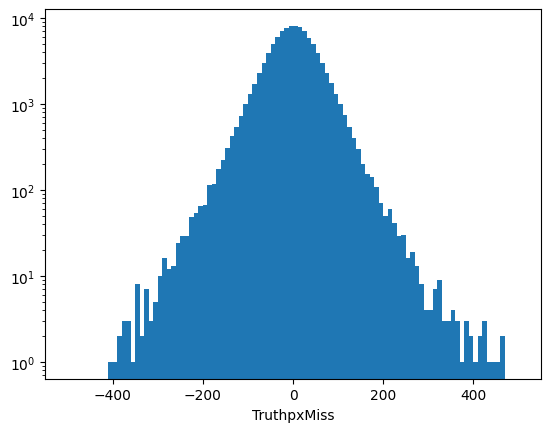

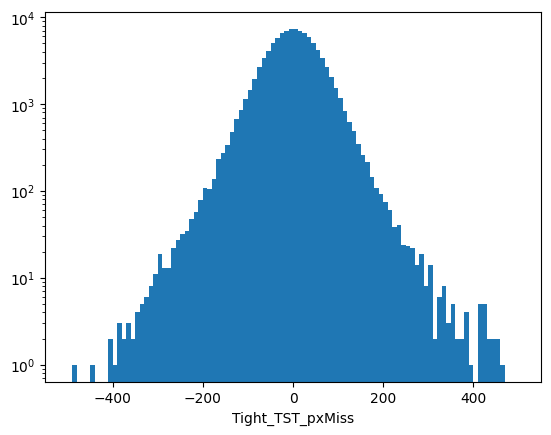

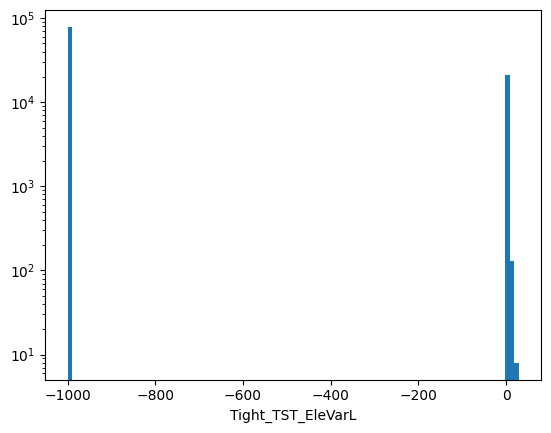

In [33]:
plot_feature('TruthpxMiss',bins=100, range=(-500,500))
plot_feature('Tight_TST_pxMiss',bins=100,range=(-500,500))
plot_feature('Tight_TST_EleVarL',bins=100)

#### Data cleaning
Some of the features have unphysical values of -1000. This is a default value for several electron/muon/jet variables in the case that an event does not contain an electron/muon/jet. Let's set this to zero.

In [36]:
df.loc[df['Tight_TST_EleVarL']==-1000,'Tight_TST_EleVarL'] = 0

0       -1000.0
2       -1000.0
3       -1000.0
4       -1000.0
5       -1000.0
          ...  
99994   -1000.0
99995   -1000.0
99996   -1000.0
99997   -1000.0
99999   -1000.0
Name: Tight_TST_EleVarL, Length: 78692, dtype: float64

Tight_TST_EleVarL
Before cleaning:


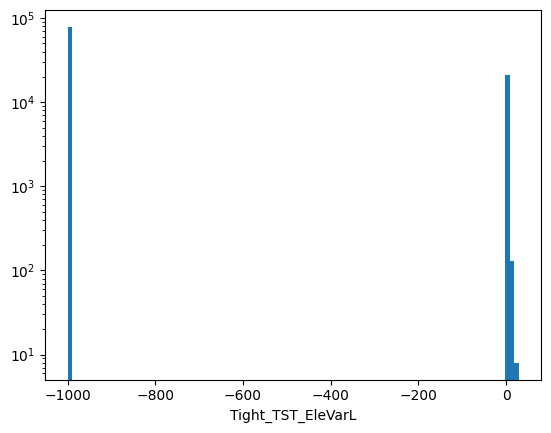

After cleaning:


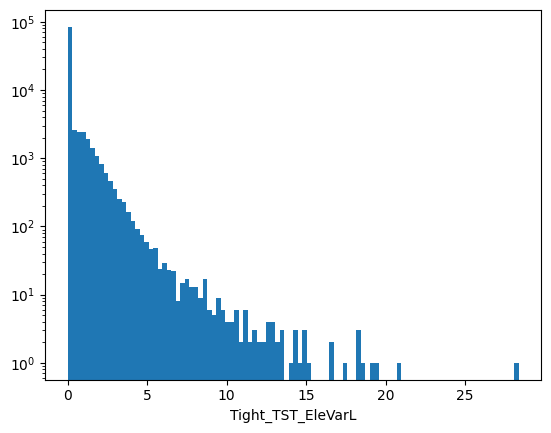

Tight_TST_EleVarT
Before cleaning:


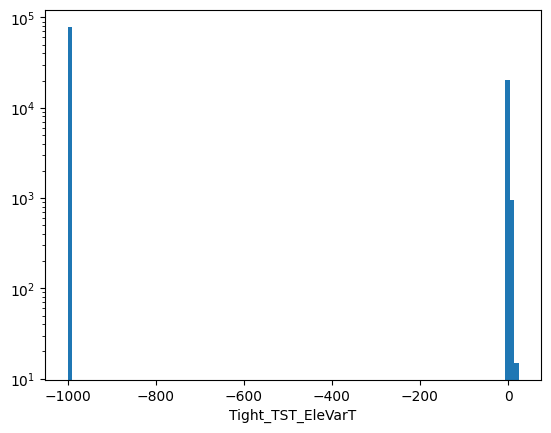

After cleaning:


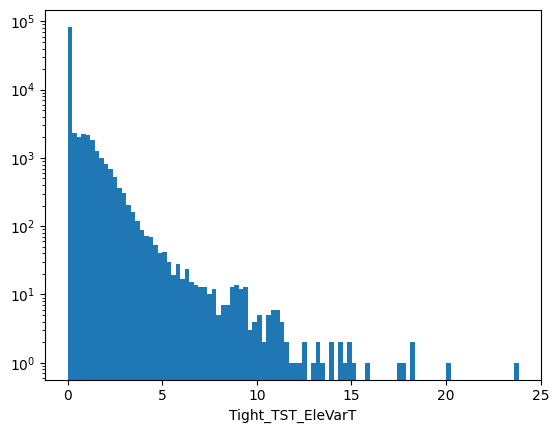

Tight_TST_MuonVarL
Before cleaning:


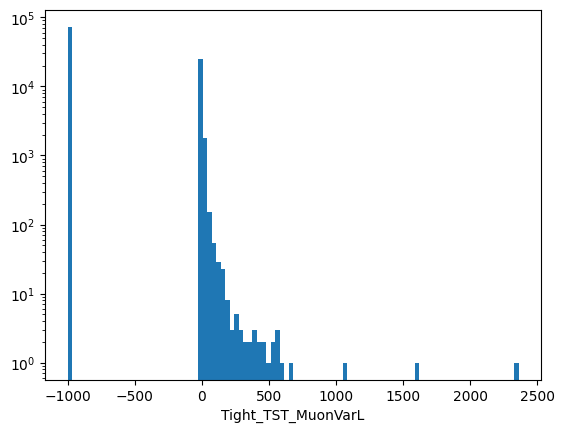

After cleaning:


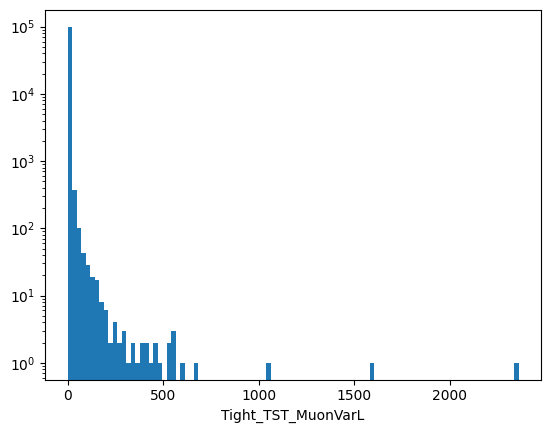

Tight_TST_MuonVarT
Before cleaning:


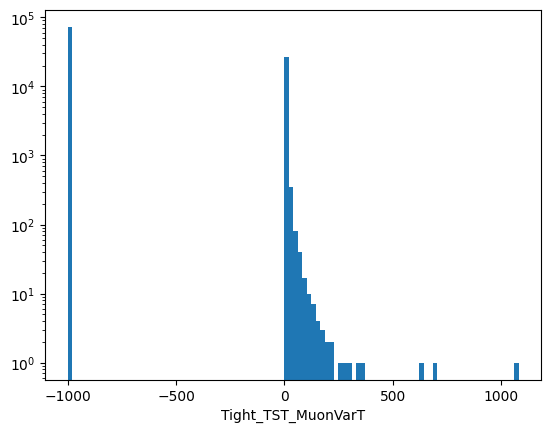

After cleaning:


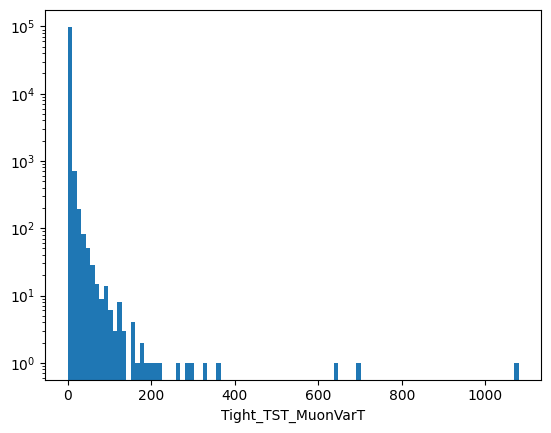

Tight_TST_JetVarL
Before cleaning:


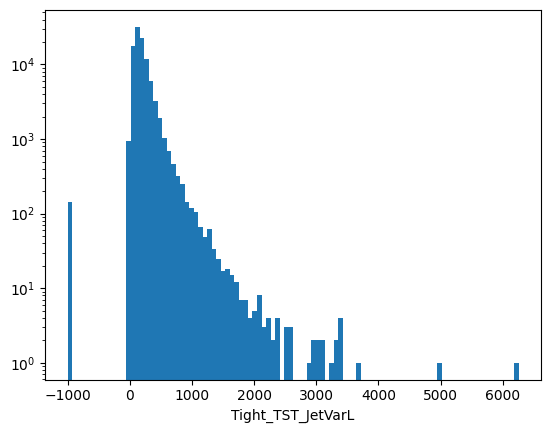

After cleaning:


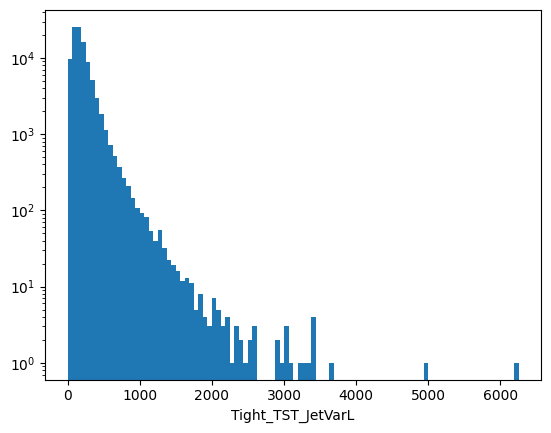

Tight_TST_JetVarT
Before cleaning:


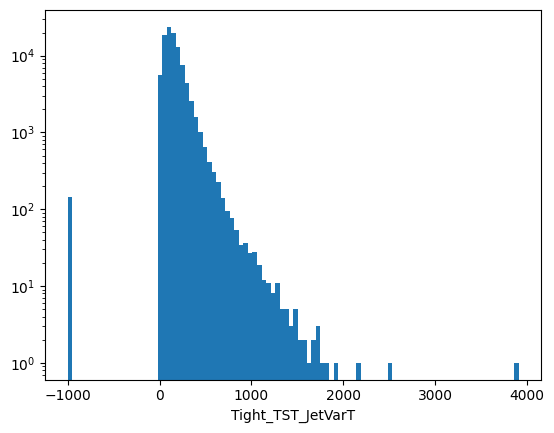

After cleaning:


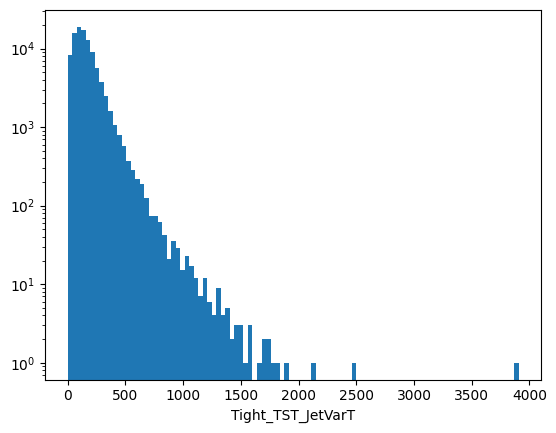

Loose_TST_JetVarL
Before cleaning:


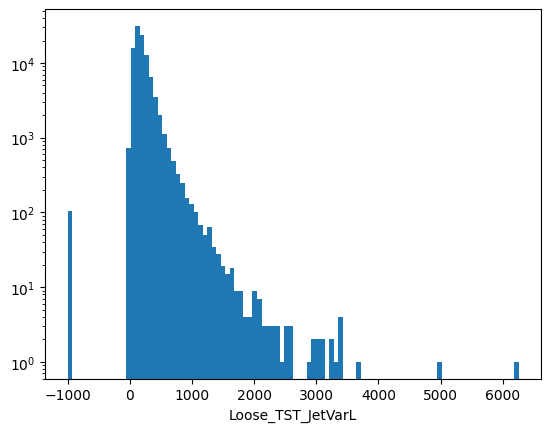

After cleaning:


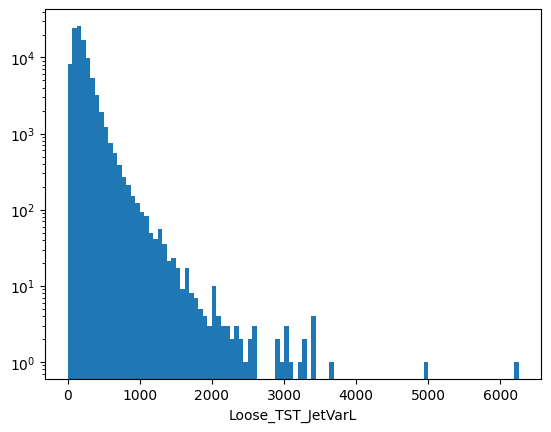

Loose_TST_JetVarT
Before cleaning:


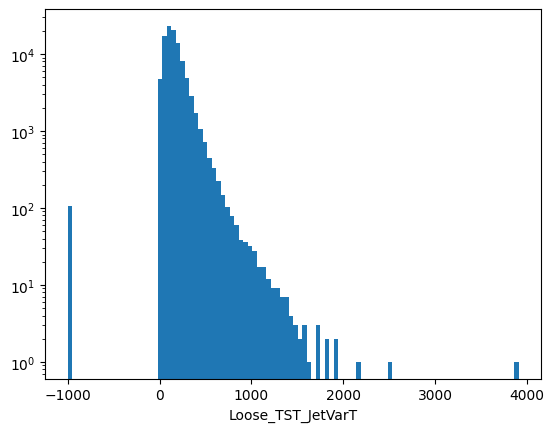

After cleaning:


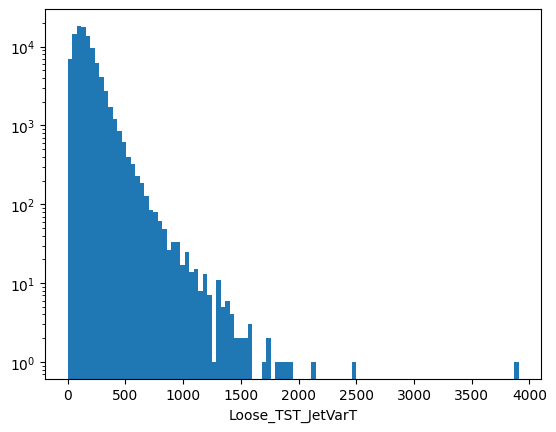

Tenacious_TST_JetVarL
Before cleaning:


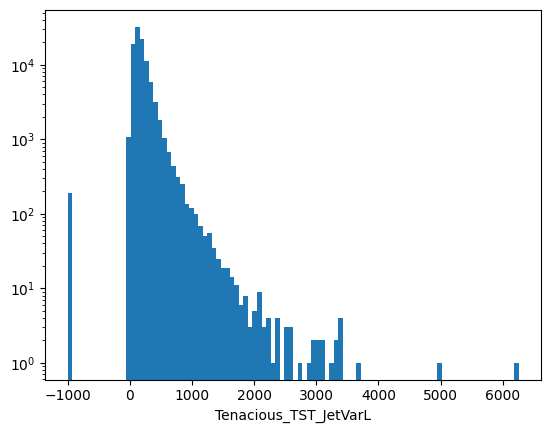

After cleaning:


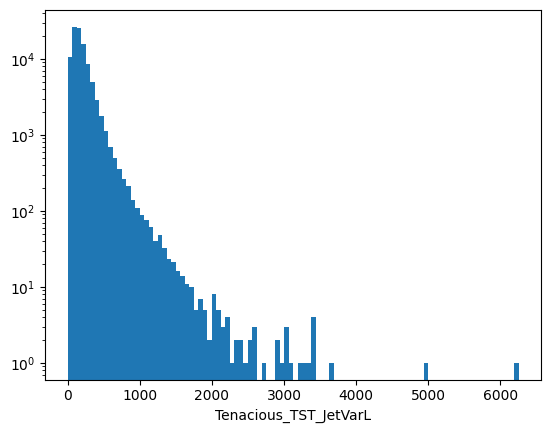

Tenacious_TST_JetVarT
Before cleaning:


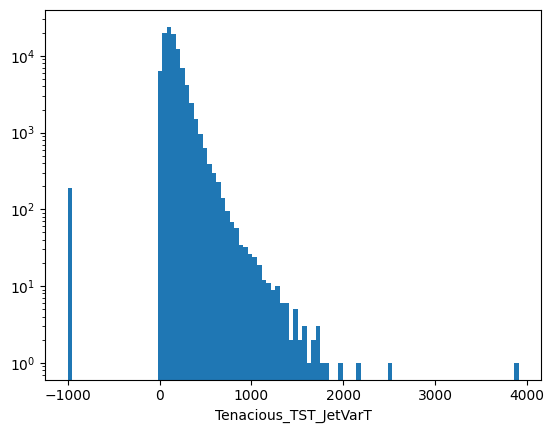

After cleaning:


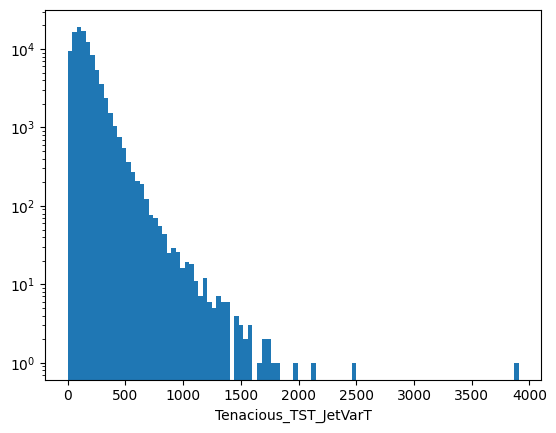

In [37]:
to_clean = ['Tight_TST_EleVarL', 'Tight_TST_EleVarT', 
            'Tight_TST_MuonVarL', 'Tight_TST_MuonVarT',
             'Tight_TST_JetVarL', 'Tight_TST_JetVarT', 
             'Loose_TST_JetVarL', 'Loose_TST_JetVarT', 
             'Tenacious_TST_JetVarL', 'Tenacious_TST_JetVarT']
for _var in to_clean:
    print('======================================')
    print(_var)
    print('Before cleaning:')
    plot_feature(_var, bins=100)
    df.loc[df[_var]==-1000, _var] = 0
    print('After cleaning:')
    plot_feature(_var, bins=100)

#### Split into train and test sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7) 

#### Set-up Keras model

In [41]:
def train_model(learning_rate=0.1, batch_size=256, n_epochs=3):
    # set-up keras model
    # Input layer
    Input_1 = Input(shape=(len(features),),name="Input")
    
    # Normalization layer (to scale input features)
    Norm_layer = tf.keras.layers.Normalization()
    # learn means and variances for feature normalization:
    Norm_layer.adapt(X_train.values)
    x = Norm_layer(Input_1)
    
    # hidden layers
    x = Dense(100,activation='relu',name='Layer1')(x)
    x = Dense(100,activation='relu',name='Layer2')(x)
    
    # output layer
    out = Dense(len(targets),activation='linear',name='Output',)(x)
    
    # put everything together and compile
    model = Model(inputs=Input_1,outputs=out)
    model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    startTime = time.perf_counter()
    history = model.fit(x = X_train, y = y_train, epochs=n_epochs, batch_size=batch_size)
    print("Train time:", str(time.perf_counter()-startTime))
    return model

In [42]:
model = train_model()

Epoch 1/3


2025-02-27 18:57:10.011806: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 813.8773     
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 613.5059  
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 621.0891  
Train time: 2.0021024950037827


In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 47)             │            95 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer1 (Dense)                  │ (None, 100)            │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer2 (Dense)                  │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,403 (177.36 KB)

 Trainable params: 15,102 (58.99 KB)

 Non-trainable params: 95 (384.00 B)

 Optimizer params: 30,206 (118.00 KB)

In [44]:
# evaluate model on test data
print(model.evaluate(X_test,y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 646.3094
640.0037231445312


In [45]:
pred_test = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


#### Plot the NN prediction compared to the existing working points

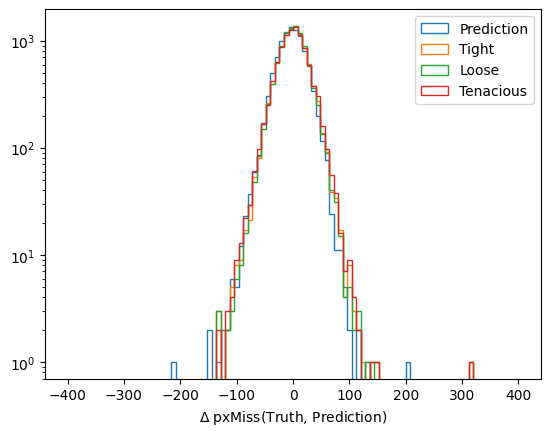

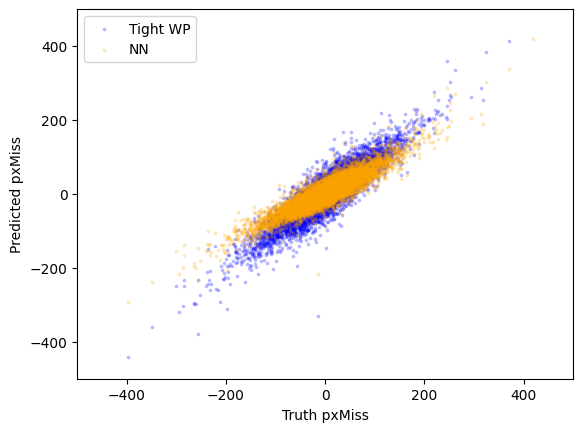

In [47]:
def plot_error(**kwargs):
    fig, ax = plt.subplots()
    ax.hist(y_test['TruthpxMiss']-pred_test[:,0], histtype='step', label='Prediction', **kwargs)
    for WP in ['Tight','Loose','Tenacious']:
        ax.hist(y_test['TruthpxMiss'] - X_test[f'{WP}_TST_pxMiss'], histtype='step', label=WP, **kwargs)
    ax.set_yscale('log')
    ax.set_xlabel(f'$\\Delta$ pxMiss(Truth, Prediction$)$')
    ax.legend()
    plt.show()

def scatter_plot(**kwargs):
    fig, ax = plt.subplots()
    ax.scatter(y_test['TruthpxMiss'], X_test['Tight_TST_pxMiss'], alpha=0.2, c='blue', label='Tight WP', **kwargs)
    ax.scatter(y_test['TruthpxMiss'], pred_test[:,0], alpha=0.2, c='orange', label='NN',**kwargs)
    ax.set_xlabel('Truth pxMiss')
    ax.set_ylabel('Predicted pxMiss')
    ax.legend()
    ax.set_xlim(-500,500)
    ax.set_ylim(-500,500)
    plt.show()

plot_error(bins=100,range=(-400,400))
scatter_plot(s=3)

### Regression metrics

**Root Mean Squared Error & Mean Absolute Error:**

<left><img src='img/RMSE.png' width=250></left> 
<right><img src='img/MAE.png' width=240></right>
* hard to tell if a model is good (eg. RMSE = 1 is good if $\bar{y}=100$ but not if $\bar{y}=1$

**Mean Absolute Percentage Error:**

<left><img src='img/MAPE.png' width=250></left> 
* Measures relative error of the prediction
* Easy to understand quality of the model
* Sensitive to $y$ scale


**Relative Squared Error & Relative Absolute Error:**

<left><img src='img/RSE.png' width=250></left> 
<right><img src='img/RAE.png' width=240></right>
* RSE shows how the prediction errors differ from the standard deviation of the real values
* Robust to $y$ scale

**Root Mean Squared Logarithmic Error:**
<left><img src='img/RMSLE.png' width=250></left> 

* Good choice when $y_i$ varies over several orders of magnitude

In [49]:
def mean_squared_error(y_pred, y_test):
    ''' 
    Evaluate the mean squared error

    Parameters:
    y_pred: numpy array of predicted values
    y_test: numpy array of true values
    '''
    mse = np.mean( (y_pred - y_test)**2 )
    return mse

def mean_absolute_error(y_pred, y_test):
    ''' 
    Evaluate the mean squared error

    Parameters:
    y_pred: numpy array of predicted values
    y_test: numpy array of true values
    '''
    mae = np.mean( np.abs(y_pred - y_test) )
    return mae

for WP in ['Tight','Loose','Tenacious']:
    mse = mean_squared_error(X_test[[f'{WP}_TST_pxMiss',f'{WP}_TST_pyMiss']].values, y_test)
    mae = mean_absolute_error(X_test[[f'{WP}_TST_pxMiss',f'{WP}_TST_pyMiss']].values, y_test)
    print(f'{WP} --> MSE = {mse}, MAE = {mae}')
pred_mse = mean_squared_error(pred_test, y_test)
pred_mae = mean_absolute_error(pred_test, y_test)
print(f'Prediction --> MSE = {pred_mse}, MAE = {pred_mae}')

Tight --> MSE = 707.4086326235017, MAE = 20.23465467068021
Loose --> MSE = 683.8380652829895, MAE = 19.88084812117826
Tenacious --> MSE = 758.930931629925, MAE = 20.97873063192406
Prediction --> MSE = 640.0036324400928, MAE = 19.48825950200543


#### Exercise: 
Add functions for the MAPE, RSE, RAE and RMSLE and use to evalute the trained model.

# To do:
- Relevant hyperparameters
- Dropout / regularisation
- SHAP values?